In [21]:
# Imports.
import numpy as np
import tensorflow as tf
import os, glob
from PIL import Image
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten
from keras.callbacks import ModelCheckpoint 
import matplotlib.pyplot as plt

In [2]:
# GPU Info (Google Colab).
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Nov 26 04:39:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Directory
local_dir = os.getcwd() + "/drive/My Drive/MA305_Project"
dataset_dir = local_dir + "/Dataset"
train_dir = dataset_dir + "/temp_train"
validation_dir = dataset_dir + '/temp_val'

In [4]:
os.listdir(validation_dir)

['Bicycle', 'Motorcycle', 'Truck', 'Horse', 'Dog']

In [5]:
# Data gens.
training_datagen =  ImageDataGenerator(
			rescale = 1./255,
      rotation_range=60,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(224, 224),
	class_mode='categorical',
  batch_size=10)
validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
	target_size=(224, 224),
	class_mode='categorical',
  batch_size=10)


Found 13250 images belonging to 5 classes.
Found 728 images belonging to 5 classes.


In [16]:
# Inception model function. This Inception network was implemented by FAIZAN SHAIKH, 
# and was modified to meet the requirements of this project. The original implementation
# can be found in the following link:
# https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/
b = keras.initializers.Constant(value=0.2)
def inception_model(input_shape):

  """
  Inception Model V1 (GoogLeNet)
  """

  input_layer  = Input(shape=input_shape)
  x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', bias_initializer=b)(input_layer)
  x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)
  x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
  x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
  x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

  # Inception 3a
  conv_1x1 = Conv2D(64, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(96, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(128, (3, 3), padding='same', activation='relu', bias_initializer=b)(conv_3x3)
  conv_5x5 = Conv2D(16, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_5x5 = Conv2D(32, (5, 5), padding='same', activation='relu', bias_initializer=b)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(32, (1, 1), padding='same', activation='relu',  bias_initializer=b)(pool_proj)
  x = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)

  # Inception 3b
  conv_1x1 = Conv2D(128, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(128, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(192, (3, 3), padding='same', activation='relu', bias_initializer=b)(conv_3x3)
  conv_5x5 = Conv2D(32, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_5x5 = Conv2D(96, (5, 5), padding='same', activation='relu', bias_initializer=b)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(64, (1, 1), padding='same', activation='relu', bias_initializer=b)(pool_proj)
  x = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)
  x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

  # Inception 4a
  conv_1x1 = Conv2D(192, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(96, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(208, (3, 3), padding='same', activation='relu', bias_initializer=b)(conv_3x3)
  conv_5x5 = Conv2D(16, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_5x5 = Conv2D(48, (5, 5), padding='same', activation='relu', bias_initializer=b)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(64, (1, 1), padding='same', activation='relu', bias_initializer=b)(pool_proj)
  x = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)

  # Auxiliary output 1
  x1 = AveragePooling2D((5, 5), strides=3)(x)
  x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
  x1 = Flatten()(x1)
  x1 = Dense(1024, activation='relu')(x1)
  x1 = Dropout(0.7)(x1)
  x1 = Dense(5, activation='softmax')(x1)

  # Inception 4b
  conv_1x1 = Conv2D(160, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(112, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(224, (3, 3), padding='same', activation='relu', bias_initializer=b)(conv_3x3)
  conv_5x5 = Conv2D(24, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_5x5 = Conv2D(64, (5, 5), padding='same', activation='relu', bias_initializer=b)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(64, (1, 1), padding='same', activation='relu', bias_initializer=b)(pool_proj)
  x = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)

  # Inception 4c
  conv_1x1 = Conv2D(128, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(128, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(256, (3, 3), padding='same', activation='relu', bias_initializer=b)(conv_3x3)
  conv_5x5 = Conv2D(24, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_5x5 = Conv2D(64, (5, 5), padding='same', activation='relu', bias_initializer=b)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(64, (1, 1), padding='same', activation='relu', bias_initializer=b)(pool_proj)
  x = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)

  # Inception 4d
  conv_1x1 = Conv2D(112, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(144, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(288, (3, 3), padding='same', activation='relu', bias_initializer=b)(conv_3x3)
  conv_5x5 = Conv2D(32, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_5x5 = Conv2D(64, (5, 5), padding='same', activation='relu', bias_initializer=b)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(64, (1, 1), padding='same', activation='relu', bias_initializer=b)(pool_proj)
  x = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)

  # Ausiliary output 2
  x2 = AveragePooling2D((5, 5), strides=3)(x)
  x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
  x2 = Flatten()(x2)
  x2 = Dense(1024, activation='relu')(x2)
  x2 = Dropout(0.7)(x2)
  x2 = Dense(5, activation='softmax')(x2)

  # Inception 4e
  conv_1x1 = Conv2D(256, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(160, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(320, (3, 3), padding='same', activation='relu', bias_initializer=b)(conv_3x3)
  conv_5x5 = Conv2D(32, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_5x5 = Conv2D(128, (5, 5), padding='same', activation='relu', bias_initializer=b)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(128, (1, 1), padding='same', activation='relu', bias_initializer=b)(pool_proj)
  x = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)
  x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

  # Inception 5a
  conv_1x1 = Conv2D(256, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(160, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(320, (3, 3), padding='same', activation='relu', bias_initializer=b)(conv_3x3)
  conv_5x5 = Conv2D(32, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_5x5 = Conv2D(128, (5, 5), padding='same', activation='relu', bias_initializer=b)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(128, (1, 1), padding='same', activation='relu', bias_initializer=b)(pool_proj)
  x = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)

  # Inception 5e
  conv_1x1 = Conv2D(384, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(192, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_3x3 = Conv2D(384, (3, 3), padding='same', activation='relu', bias_initializer=b)(conv_3x3)
  conv_5x5 = Conv2D(48, (1, 1), padding='same', activation='relu', bias_initializer=b)(x)
  conv_5x5 = Conv2D(128, (5, 5), padding='same', activation='relu', bias_initializer=b)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(128, (1, 1), padding='same', activation='relu', bias_initializer=b)(pool_proj)
  x = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3)

  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.4)(x)
  x = Dense(5, activation='softmax', name='output')(x)

  return Model(input_layer, [x, x1, x2])
# End of Inception Network model.

# Import the Inception model, and print the summary.
input_shape = (224, 224, 3)
model = inception_model(input_shape)
model.summary()


Model: "functional_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_168[0][0]                 
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 56, 56, 64)   4160        max_pooling2d_27[0][0]           
_______________________________________________________________________________________

In [18]:
# Load weights from previous runs.
model.load_weights(os.getcwd() + "/drive/My Drive/MA305_Project/best_weights_inception_5_classes.h5")

In [10]:
# Model compilation and fit.
checkpoint = ModelCheckpoint('best_weights_inception_5_classes.h5', 
                                 verbose=1, monitor='loss', 
                                 save_best_only=True, mode='auto')
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

# Training.
train = False
if train:
  model.compile(loss ='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  history = model.fit(train_generator, validation_data = validation_generator, 
                      epochs=50, batch_size = 10, callbacks=[checkpoint])


 Class: Bicycle 150


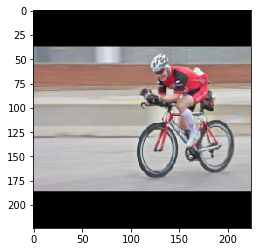

Image corresponds to class 1 (Bicycle),
    with confidence of 91.91%.


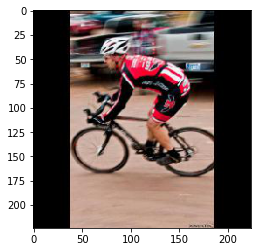

Image corresponds to class 1 (Bicycle),
    with confidence of 95.29%.

 Class: Dog 150


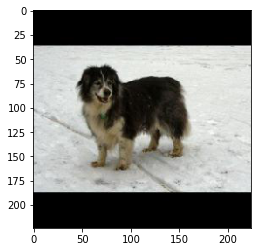

Image corresponds to class 2 (Dog),
    with confidence of 98.75%.


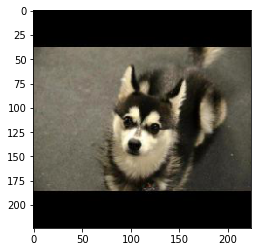

Image corresponds to class 2 (Dog),
    with confidence of 96.32%.


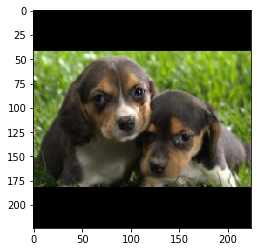

Image corresponds to class 2 (Dog),
    with confidence of 98.82%.


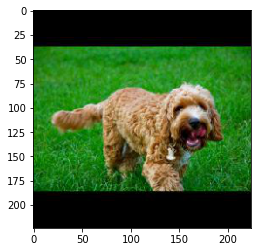

Image corresponds to class 2 (Dog),
    with confidence of 99.26%.

 Class: Horse 150


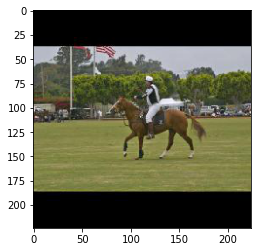

Image corresponds to class 3 (Horse),
    with confidence of 99.93%.


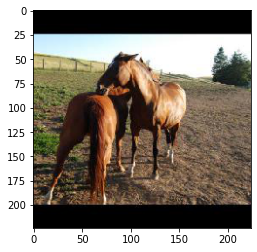

Image corresponds to class 3 (Horse),
    with confidence of 92.63%.


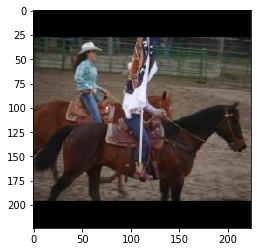

Image corresponds to class 3 (Horse),
    with confidence of 92.05%.


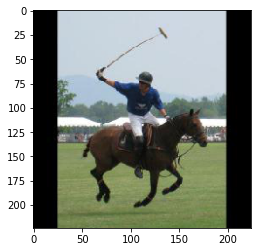

Image corresponds to class 3 (Horse),
    with confidence of 100.0%.

 Class: Motorcycle 128


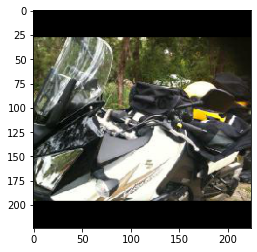

Image corresponds to class 4 (Motorcycle),
    with confidence of 96.42%.


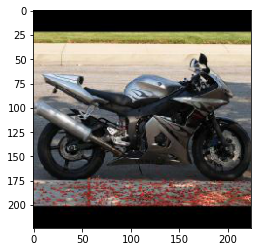

Image corresponds to class 4 (Motorcycle),
    with confidence of 99.56%.


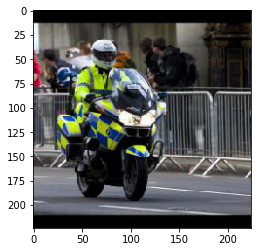

Image corresponds to class 4 (Motorcycle),
    with confidence of 91.75%.


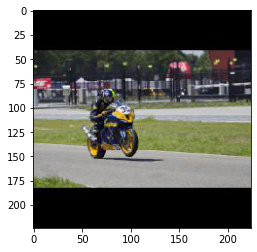

Image corresponds to class 4 (Motorcycle),
    with confidence of 98.95%.

 Class: Truck 150


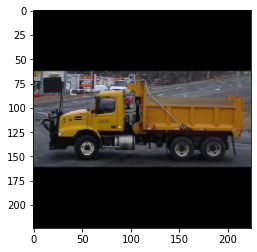

Image corresponds to class 5 (Truck),
    with confidence of 95.07%.


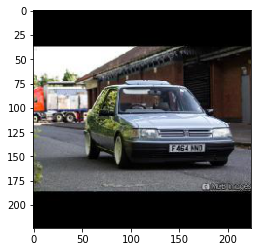

Image corresponds to class 5 (Truck),
    with confidence of 91.73%.


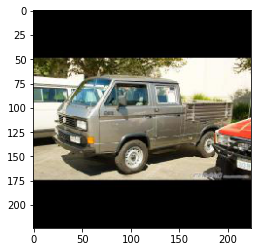

Image corresponds to class 5 (Truck),
    with confidence of 94.57%.


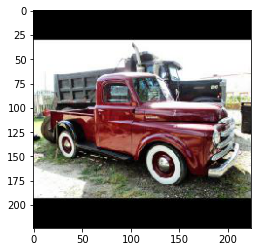

Image corresponds to class 5 (Truck),
    with confidence of 97.3%.


In [23]:
# Test images.
labels = validation_generator.class_indices
labels = dict([(value, key) for key, value in labels.items()]) 
test_classes = ['Bicycle', 'Dog', 'Horse', 'Motorcycle', 'Truck']

# Test images for each class.
for test_class in test_classes:

  # Define directory to images.
  cur_dir = validation_dir + '//' + test_class + '//'
  class_files = os.listdir(validation_dir + '//' + test_class)
  print('\n Class:', test_class, len(class_files))

  # Process 50 validation images of each class.
  ct = 1
  for i in range(0, 50):

    # Image pre-processing.
    img_dir = cur_dir + class_files[i]
    pil_image = tf.keras.preprocessing.image.load_img(img_dir, target_size=(224, 224))
    test_image = tf.keras.preprocessing.image.img_to_array(pil_image)   # Numpy array with shape (224, 224, 3)
    test_image = test_image.reshape((1,) + test_image.shape)     # Numpy array with shape (1, 224, 224, 3)
    test_image /= 255.0   # Rescale by 1/255

    # Predict using the model. 
    results = model.predict(test_image)

    # Identify the class with the highest probability.
    results_array = np.asarray([r[0] for r in results])
    scores = np.mean(results_array, axis=0)
    idx = np.argmax(scores)
    score = 100*scores[idx]
    label = labels[idx]

    # Print some images (that have been correctly classified and
    # have a confidence above 90%).
    if score > 90 and label == test_class and ct < 5:
      plt.imshow(pil_image)
      plt.show()
      print('Image corresponds to class {} ({}),'.format(idx + 1, label))
      print("    with confidence of {}%.".format(round(score, 2)))
      ct += 1
